In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../src')))

import pandas as pd
import numpy as np
import geopandas as gpd
import json
import seaborn as sns

from shapely.geometry import Point
from matplotlib import pyplot as plt
%matplotlib inline

import requests
import time

import transdist
import roads
import models

print('Libraries loaded.')

Libraries loaded.


# Load NREL techno-economic dataset for Texas

This dataset contains all sites recommended by NREL for wind development

In [3]:
nrel_us = pd.read_csv('../data/nrel-techno-sites.csv')
print('Total number of sites',len(nrel_us))
#filter out all sites except those in Texas
nrel_state = nrel_us[(nrel_us.State == 'Texas')]
print('Numberr of sites in Texas',len(nrel_state))
#create list of (lat,lon) pairs
point_list = list(zip(nrel_state['latitude'],nrel_state['longitude']))
nrel_state.head()

Total number of sites 126692
Numberr of sites in Texas 7869


,site_id,longitude,latitude,State,County,fraction_of_usable_area,power_curve,capacity,wind_speed,capacity_factor,full_timeseries_directory,full_timeseries_path
169,169,-97.460358,25.896492,Texas,Cameron,0.0049,2,2,7.46,0.433,0,0/169.nc
251,251,-97.738098,26.032654,Texas,Cameron,0.5680,2,10,7.45,0.414,0,0/251.nc
288,288,-97.208252,26.059063,Texas,Cameron,0.0801,2,2,8.18,0.506,0,0/288.nc
367,367,-98.073364,26.078449,Texas,Hidalgo,0.9851,2,16,7.17,0.363,0,0/367.nc
494,494,-98.311340,26.143227,Texas,Hidalgo,0.9475,2,16,7.06,0.358,0,0/494.nc


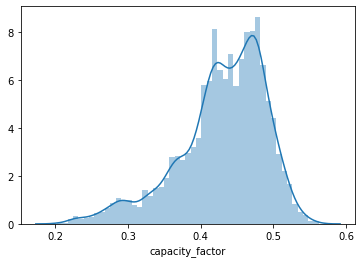

In [4]:
#plot capacity factor distribution
sns.distplot(nrel_state['capacity_factor'])

# Get closest transmission lines

Calculate closest transmission lines

In [5]:
transdist.get_tx('../data/long-trans-data-TX.geojson')
trans_idx_list,trans_point_list,trans_dist_list = list(zip(*[
    transdist.find_closest_trans_point(latlon) for latlon in point_list
]))

trans_df = pd.DataFrame({
    'site_id' : nrel_ca['site_id'],
    'trans_idx' : trans_idx_list,
    'latitude' : [latlon[0] for latlon in trans_point_list],
    'longitude': [latlon[1] for latlon in trans_point_list],
    'distance': trans_dist_list
})
trans_df

Save closest transmission lines

In [ ]:
#trans_df = pd.to_pickle('../data/trans-df-tx.pkl')

Load closest transmission lines

In [7]:
trans_df = pd.read_pickle('../data/trans-df-tx.pkl')
trans_df

,site_id,trans_idx,latitude,longitude,distance
169,169,833,25.888472,-97.424833,2.279919
251,251,882,26.087197,-97.785635,4.778612
288,288,848,26.084680,-97.267434,4.080237
367,367,885,26.078824,-98.075022,0.106241
494,494,884,26.103226,-98.213942,6.649775
...,...,...,...,...,...
27791,27791,644,36.081104,-102.532032,36.307250
27965,27965,644,36.081104,-102.532032,38.899448
27966,27966,644,36.081104,-102.532032,38.092980
27967,27967,644,36.081104,-102.532032,35.838002


Plot log transmission line distances

(array([  10.,   43.,  109.,  390.,  882., 1683., 2034., 1558.,  897.,
         263.]),
 array([-1.98726426, -1.57956858, -1.1718729 , -0.76417722, -0.35648154,
         0.05121414,  0.45890983,  0.86660551,  1.27430119,  1.68199687,
         2.08969255]),
 <a list of 10 Patch objects>)

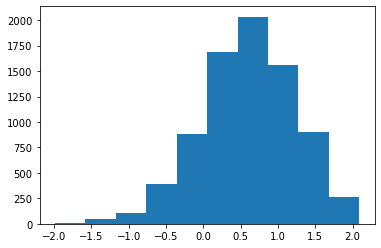

In [9]:
plt.hist(np.log10(trans_df['distance'])); plt.show()

# Find closest roads

## Calculate distances to nearest residential roads

The following cell may need to be run multiple times if the Overpass API limit is reached

In [274]:
#find closest residential roads
res_road_data_list = []
i = 0
while i < len(point_list[:]):
    if i%50 == 0:
        print(i)
    latlon = point_list[i]
    res_road_data_list.append((nrel_state['site_id'].iloc[i],i) + roads.get_closest_road_radii(latlon,debug=False,valid_highways = ['residential']))
    i = i + 1

5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850


In [279]:
#check that list site IDs match the NREL database
assert(np.all(nrel_state['site_id'].iloc[:len(res_road_data_list)] == [x[0] for x in res_road_data_list]))

Create the residential road database and save

In [277]:
res_road_df= pd.DataFrame((lambda rlist: {'site_id' : nrel_state['site_id'].iloc[:len(res_road_data_list)], 'i' : rlist[1], 'latitude' : [x[0] for x in rlist[2]],
              'longitude' : [x[1] for x in rlist[2]] ,'distance' : rlist[3], 'label' : rlist[4]})(list(zip(*res_road_data_list)))
            )
display(res_road_df)
#res_road_df.to_pickle('../data/nrel-techno-tx/roads/res-road0:7869.pkl',protocol=3)


,site_id,i,latitude,longitude,distance,label
169,169,0,25.896713,-97.459846,0.035290,residential
251,251,1,26.031307,-97.736630,0.130132,residential
288,288,2,26.061464,-97.205937,0.219165,residential
367,367,3,26.077726,-98.068152,0.327825,residential
494,494,4,26.140845,-98.305813,0.380563,residential
...,...,...,...,...,...,...
27791,27791,7864,36.512588,-103.014083,3.853156,residential
27965,27965,7865,36.492353,-103.053419,1.844439,residential
27966,27966,7866,36.512465,-103.014439,2.187866,residential
27967,27967,7867,36.486838,-102.905068,1.507610,residential


/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  10.,   43.,  165.,  376.,  918., 1806., 2005., 1150.,  690.,
         499.]),
 array([-2.66326894, -2.31755457, -1.9718402 , -1.62612584, -1.28041147,
        -0.9346971 , -0.58898273, -0.24326837,  0.102446  ,  0.44816037,
         0.79387474]),
 <a list of 10 Patch objects>)

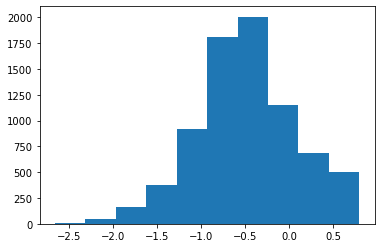

In [289]:
plt.hist(np.log10(res_road_df['distance'])); plt.show()

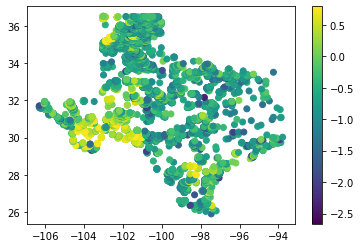

In [292]:
plt.scatter(res_road_df['longitude'],res_road_df['latitude'],c=np.log10(res_road_df['distance'])); plt.colorbar()

## Calculate distances to nearest viable roads

Calculate distances to nearest viable roads (nonresidental paved roads). The following cell may need to be run multiple times if the Overpass API limit is reached

In [152]:
#find closest roads

road_data_list = []
i = 0
while i < len(point_list[:]):
    if i%50 == 0:
        print(i)
    latlon = point_list[i]
    road_data_list.append((i,) + roads.get_closest_road_radii(latlon,debug=False,))
    i = i + 1

5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850


Create and save road database

In [154]:
road_df= pd.DataFrame((lambda rlist: {'site_id' : nrel_state['site_id'].iloc[:len(road_data_list)], 'i' : rlist[0], 'latitude' : [x[0] for x in rlist[1]],
              'longitude' : [x[1] for x in rlist[1]] ,'distance' : rlist[2], 'label' : rlist[3]})(list(zip(*road_data_list)))
            )
display(road_df)
#road_df.to_pickle('../data/nrel-techno-tx/roads/nonres-road0:7869.npy',protocol=3)

,site_id,i,latitude,longitude,distance,label
169,169,0,25.896175,-97.460796,0.034964,tertiary
251,251,1,26.032830,-97.738788,0.044568,primary
288,288,2,26.071840,-97.216763,1.026501,primary
367,367,3,26.078643,-98.074974,0.100975,primary
494,494,4,26.143035,-98.312744,0.088229,trunk
...,...,...,...,...,...,...
27791,27791,7864,36.448977,-103.009130,2.201790,unclassified
27965,27965,7865,36.480363,-103.025504,0.134556,unclassified
27966,27966,7866,36.500527,-103.000867,1.223024,unclassified
27967,27967,7867,36.500452,-102.932340,0.886875,unclassified


/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


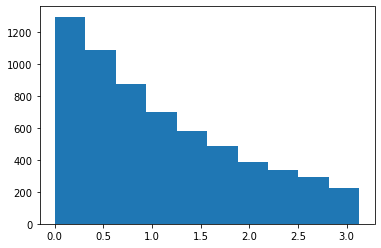

In [18]:
plt.hist(road_df['distance']); plt.show()

## Load road databases

In [16]:
res_road_df = pd.read_pickle('../data/nrel-techno-tx/roads/res-road0:7869.pkl')
road_df = pd.read_pickle('../data/nrel-techno-tx/roads/nonres-road0:7869.pkl')

# incorporate model data

Load models

In [19]:
import pickle as pkl
with open('../models/land-price-17.pkl','rb') as f:
    land_value_model = pkl.load(f)
with open('../models/cf-model-21-tech.pkl','rb') as f:
    capacity_class_model = pkl.load(f)

Use capacity factor model to label high/low performance sites

In [20]:
#format data for classifier
X_cap = pd.concat([
    nrel_state[['site_id','longitude','capacity_factor']].set_index('site_id'),
    pd.DataFrame({'p_year' : np.full([len(nrel_state)],2017)},index=nrel_state['site_id'])
],axis=1)
best_threshold = 0.6807357617109732 #threshold chosen to achieve desired precision
#calculate predicted labels
y_cap = models.pred_thresh(capacity_class_model,X_cap,th=best_threshold)

print(np.count_nonzero(y_cap),'/',len(y_cap),'high capacity sites')
capacity_class = y_cap

5671 / 7869 high capacity sites


Use land cost regression to estimate site land price per acre

In [21]:
X_land = nrel_state[['latitude','longitude']]
y_land,y_land_std = land_value_model.predict(X_land,return_std=True)
land_value = 10**y_land

# combine data

Combine dataframes to yield final database

In [24]:
#make sure all site ids match
assert(np.all((nrel_state['site_id'] == trans_df['site_id']) & (nrel_state['site_id'] == road_df['site_id'])))

#columns to include from each dataframe
nrel_names = 'site_id,latitude,longitude,County,capacity_factor'.split(',')
trans_names = 'site_id,trans_idx,latitude,longitude,distance'.split(',')
road_names = 'site_id,latitude,longitude,distance'.split(',')
res_road_names = 'site_id,latitude,longitude,distance'.split(',')
#concatenate dataframes
df = pd.concat([
    nrel_state[nrel_names].set_index('site_id'),
    trans_df[trans_names].set_index('site_id'),
    road_df[road_names].set_index('site_id'),
    res_road_df[res_road_names].set_index('site_id'),
    pd.DataFrame({
        'site_id' : nrel_state['site_id'], 'capacity_class' : capacity_class,
        'land_value' : land_value,'land_value_logstd' : y_land_std
    }).set_index('site_id')
],axis=1,keys=['nrel','trans','road','res_road','ML'])
df

nrel                                          trans             \
          latitude   longitude   County capacity_factor trans_idx   latitude   
site_id                                                                        
169      25.896492  -97.460358  Cameron           0.433       833  25.888472   
251      26.032654  -97.738098  Cameron           0.414       882  26.087197   
288      26.059063  -97.208252  Cameron           0.506       848  26.084680   
367      26.078449  -98.073364  Hidalgo           0.363       885  26.078824   
494      26.143227  -98.311340  Hidalgo           0.358       884  26.103226   
...            ...         ...      ...             ...       ...        ...   
27791    36.466068 -102.975739   Dallam           0.436       644  36.081104   
27965    36.481190 -103.023315   Dallam           0.420       644  36.081104   
27966    36.482792 -103.000519   Dallam           0.420       644  36.081104   
27967    36.487591 -102.932129   Dallam           0.445       644  36.081104   
28131    36.499516 -103.025330   Dallam           0.444       644  36.081104   

                                     road                         res_road  \
          longitude   distance   latitude   longitude  distance   latitude   
site_id                                                                      
169      -97.424833   2.279919  25.896175  -97.460796  0.034964  25.896713   
251      -97.785635   4.778612  26.032830  -97.738788  0.044568  26.031307   
288      -97.267434   4.080237  26.071840  -97.216763  1.026501  26.061464   
367      -98.075022   0.106241  26.078643  -98.074974  0.100975  26.077726   
494      -98.213942   6.649775  26.143035  -98.312744  0.088229  26.140845   
...             ...        ...        ...         ...       ...        ...   
27791   -102.532032  36.307250  36.448977 -103.009130  2.201790  36.512588   
27965   -102.532032  38.899448  36.480363 -103.025504  0.134556  36.492353   
27966   -102.532032  38.092980  36.500527 -103.000867  1.223024  36.512465   
27967   -102.532032  35.838002  36.500452 -102.932340  0.886875  36.486838   
28131   -102.532032  39.880884  36.500528 -103.025619  0.071628  36.512313   

                                          ML                                 
          longitude  distance capacity_class   land_value land_value_logstd  
site_id                                                                      
169      -97.459846  0.035290              1  7661.198190          0.387342  
251      -97.736630  0.130132              1  6440.220342          0.295477  
288      -97.205937  0.219165              1  8406.848485          0.435271  
367      -98.068152  0.327825              0  5174.235727          0.266716  
494      -98.305813  0.380563              0  4320.702080          0.264095  
...             ...       ...            ...          ...               ...  
27791   -103.014083  3.853156              1  3876.243634          0.666039  
27965   -103.053419  1.844439              1  3927.128267          0.682710  
27966   -103.014439  2.187866              1  3919.716977          0.676243  
27967   -102.905068  1.507610              0  3897.462019          0.656392  
28131   -103.015172  1.048014              0  3961.501697          0.686311  

[7869 rows x 17 columns]

Remove sites with missing values

In [25]:
clean_df = df.dropna()
print(np.count_nonzero(clean_df[('ML','capacity_class')]),'/',len(clean_df), 'remaining sites')


4629 / 6183 remaining sites


Save dataframe

In [306]:
#clean_df.to_pickle('../app/data/results-21.pkl',protocol = 3)